# **Import Libraries**

In [ ]:
# Section: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# **Libraries for Machine Learning**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# **Load the dataset**

In [ ]:
# Section: Load Dataset
df = pd.read_csv("/content/vehicles.csv", low_memory=False)
print("Shape:", df.shape)
df.head()

Shape: (48617, 84)


,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,...,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
0,14.167143,0.0,0.0,0.0,19,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
1,27.046364,0.0,0.0,0.0,9,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
2,11.018889,0.0,0.0,0.0,23,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
3,27.046364,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
4,15.658421,0.0,0.0,0.0,17,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


# **Data Cleaning & Leakage Prevention**

In [ ]:
# Section: Drop Leakage Columns
leakage_cols = [
    'co2A', 'comb08', 'combA08', 'barrels08', 'barrelsA08',
    'fuelCost08', 'fuelCostA08', 'co2TailpipeGpm', 'co2TailpipeAGpm',
    'city08', 'cityA08', 'highway08', 'highwayA08'
]
df.drop(columns=leakage_cols, inplace=True, errors='ignore')


# **Select Useful Columns & Drop Nulls**

In [ ]:
# Section: Select Features and Clean Nulls
selected_cols = [
    'make', 'model', 'year', 'cylinders', 'displ', 'fuelType',
    'drive', 'trany', 'VClass', 'co2'
]
df = df[selected_cols].dropna()
print("Cleaned Shape:", df.shape)


Cleaned Shape: (46344, 10)


# **Split Features and Target**

In [ ]:
# Section: Feature-Target Split
X = df.drop(columns='co2')
y = df['co2']


# **Preprocessing Pipeline**

In [ ]:
# Section: Preprocessing Pipeline
categorical = ['make', 'model', 'fuelType', 'drive', 'trany', 'VClass']
numeric = ['year', 'cylinders', 'displ']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
], remainder='passthrough')


# **Train-Test Split**

In [ ]:
# Section: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **Train Random Forest Model**

In [ ]:
# Section: Train Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))


Random Forest R²: 0.9974464778086294
Random Forest RMSE: 10.06522460701715


# **Visualize Random Forest Results**

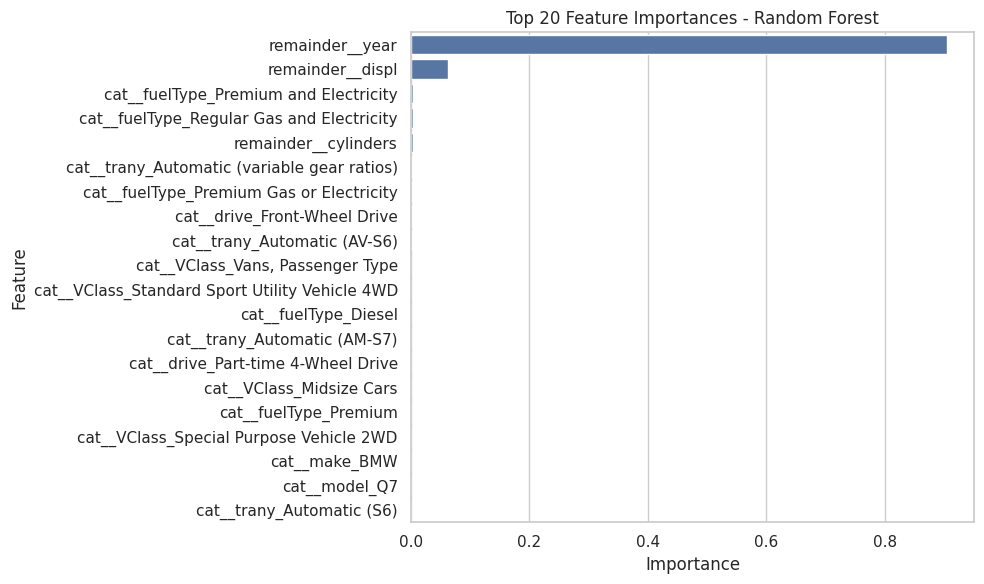

In [ ]:
# Section: Visualize RF Feature Importance
importances = rf_pipeline.named_steps['model'].feature_importances_
feature_names = rf_pipeline.named_steps['preprocess'].get_feature_names_out()

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 20 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


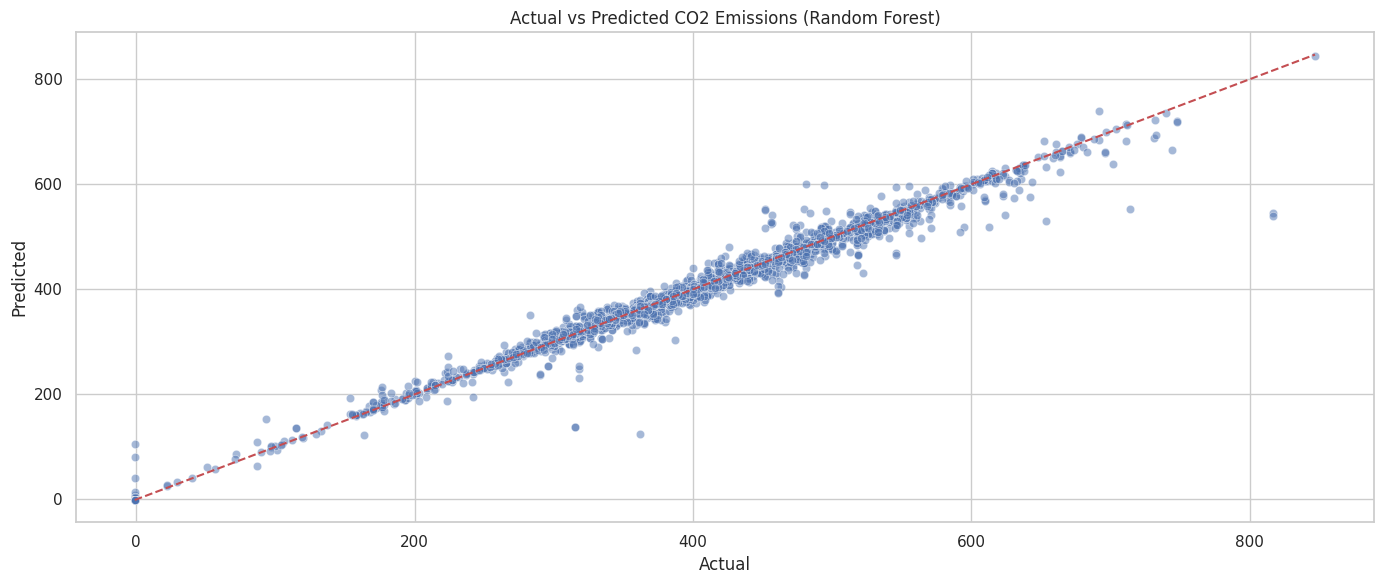

In [ ]:
# Section: RF Actual vs Predicted Plot
plt.figure(figsize=(14,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title("Actual vs Predicted CO2 Emissions (Random Forest)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


# **Train XGBoost Model with Grid Search**

In [ ]:
# Section: XGBoost + GridSearchCV
xgb_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [3, 5],
}

grid = GridSearchCV(xgb_pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

y_pred_xgb = grid.predict(X_test)

print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))


XGBoost R²: 0.991543710231781
XGBoost RMSE: 18.31654578814944


# **Visualize XGBoost Results**

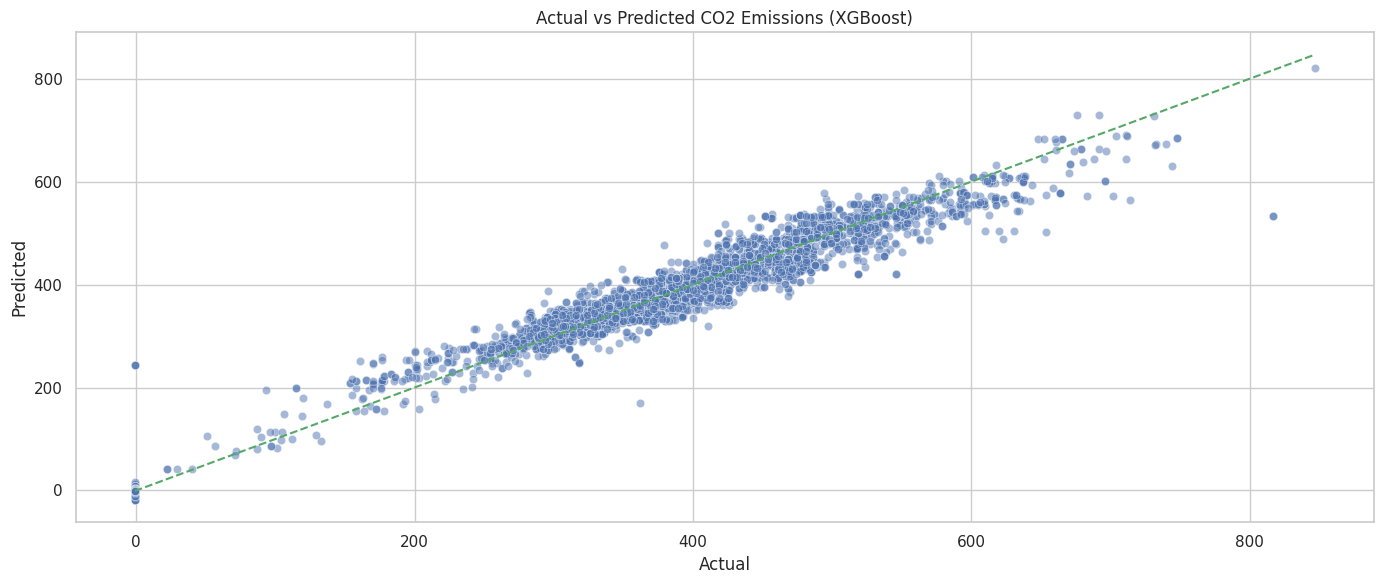

In [ ]:
# Section: XGBoost Actual vs Predicted Plot
plt.figure(figsize=(14,6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--g')
plt.title("Actual vs Predicted CO2 Emissions (XGBoost)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


# **Save Best XGBoost Model**

In [ ]:
# Section: Save Trained Model
joblib.dump(grid.best_estimator_, "xgb_model_co2.pkl")

['xgb_model_co2.pkl']